In [1]:
# Import dependencies
import pandas as pd
from pathlib import Path
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import hvplot.pandas
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
# Read in data from csv file
wine_data = Path("Resources/winemag-data-130k-v2.csv")
# Convert to dataframe
wine_df = pd.read_csv(wine_data)
wine_df.head(5)

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
# Clean and transform data
# Drop unnecessary columns
df = wine_df.loc[:,["country", "description", "points",
                                    "province", "variety"]]
# Drop null values
df = df.dropna(how='any')
df.head(5)

,country,description,points,province,variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,Sicily & Sardinia,White Blend
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,Douro,Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and...",87,Oregon,Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,Michigan,Riesling
4,US,"Much like the regular bottling from 2012, this...",87,Oregon,Pinot Noir


In [27]:
country

NameError: name 'country' is not defined

In [ ]:
df.drop(["Hungary", "Romania", ""],axis=0,inplace=True)


In [4]:
# Transform words into vectors using NLP
# Drop stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
df['description'] = df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jackie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,country,description,points,province,variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,Sicily & Sardinia,White Blend
1,Portugal,"This ripe fruity, wine smooth still structured...",87,Douro,Portuguese Red
2,US,"Tart snappy, flavors lime flesh rind dominate....",87,Oregon,Pinot Gris
3,US,"Pineapple rind, lemon pith orange blossom star...",87,Michigan,Riesling
4,US,"Much like regular bottling 2012, comes across ...",87,Oregon,Pinot Noir


In [5]:
# Lemmatization
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)
df['description'] = df['description'].apply(lemmatize_words)
df.head()

[nltk_data] Downloading package wordnet to /Users/jackie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,country,description,points,province,variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,Sicily & Sardinia,White Blend
1,Portugal,"This ripe fruity, wine smooth still structured...",87,Douro,Portuguese Red
2,US,"Tart snappy, flavor lime flesh rind dominate. ...",87,Oregon,Pinot Gris
3,US,"Pineapple rind, lemon pith orange blossom star...",87,Michigan,Riesling
4,US,"Much like regular bottle 2012, come across rat...",87,Oregon,Pinot Noir


In [6]:
# Tokenize descriptions to split sentences into word components
descriptions = df.description.apply(gensim.utils.simple_preprocess)
descriptions

0         [aromas, include, tropical, fruit, broom, brim...
1         [this, ripe, fruity, wine, smooth, still, stru...
2         [tart, snappy, flavor, lime, flesh, rind, domi...
3         [pineapple, rind, lemon, pith, orange, blossom...
4         [much, like, regular, bottle, come, across, ra...
                                ...                        
129966    [notes, honeysuckle, cantaloupe, sweeten, deli...
129967    [citation, give, much, decade, bottle, age, pr...
129968    [well, drained, gravel, soil, give, wine, cris...
129969    [dry, style, pinot, gris, crisp, acidity, it, ...
129970    [big, rich, off, dry, power, intense, spicines...
Name: description, Length: 129907, dtype: object

In [7]:
# Word2Vec model
# Create the model
model = gensim.models.Word2Vec(window=1, min_count=1, workers=8)
# Build its vocabulary
model.build_vocab(descriptions, progress_per=100)
# Train the model
model.train(descriptions, total_examples=model.corpus_count, epochs= model.epochs)
# Save the model to use later
model.save("Resources/descriptions.model")

In [8]:
# Test the model looking for similar words
model.wv.most_similar("fleshy")

[('plump', 0.8141403794288635),
 ('pulpy', 0.7697402834892273),
 ('plush', 0.7274256944656372),
 ('luscious', 0.7117027044296265),
 ('juicy', 0.7093358039855957),
 ('mouthfilling', 0.7075841426849365),
 ('succulent', 0.7027739882469177),
 ('lush', 0.701250433921814),
 ('chunky', 0.6987307071685791),
 ('broad', 0.692582905292511)]

In [9]:
# Test the model with similarity of different words
model.wv.similarity(w1="sweet",w2="fruity")

0.39745206

In [10]:
# Get vector representations of descriptions

# define our function that creates description vectors:
def get_desc_vec(document):
    return np.array(sum(model.wv[word] for word in document)/len(document))

desc_vecs = descriptions.apply(get_desc_vec).tolist()

# for 
# sum(model.wv[d] for d in descriptions[0])/len(descriptions[0])
# model.wv['aromas']
# for desc in descriptions

In [11]:
desc_vec_df = pd.DataFrame(desc_vecs)

In [12]:
desc_vec_df.values

array([[-0.24017394,  0.26588377, -0.17075847, ..., -0.3288536 ,
         0.04992463, -0.3938225 ],
       [-0.30644062,  0.25632584,  0.23371716, ..., -0.32846415,
        -0.18497515, -0.43848276],
       [-0.47007433,  0.17251335, -0.07295186, ..., -0.6120887 ,
         0.1103909 , -0.3843808 ],
       ...,
       [-0.15633409,  0.01994993,  0.15464059, ..., -0.20119208,
        -0.11565828, -0.3286974 ],
       [-0.2601371 ,  0.03483663,  0.1659561 , ..., -0.34224856,
        -0.21086724, -0.4585202 ],
       [-0.36341023,  0.04756146,  0.1102504 , ..., -0.17605205,
        -0.18726487, -0.3949814 ]], dtype=float32)

In [13]:
# Get vector representations of descriptions
# Define our function that creates description vectors:
def get_desc_vec(document):
    return np.array(sum(model.wv[word] for word in document)/len(document))

desc_vecs = descriptions.apply(get_desc_vec).tolist()

In [14]:
# Elbow Method to find the optimal number of clusters
num_clusters_range = range(1, 11)

wcss = []
for k in num_clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(desc_vec_df)
    wcss.append(kmeans.inertia_)

# Create a DataFrame for the elbow curve
df_elbow = pd.DataFrame({"k_value": num_clusters_range, "inertia_value": wcss})

# Plot the elbow curve using hvplot
elbow_curve = df_elbow.hvplot.line(x="k_value", y="inertia_value", title="Elbow Curve")
elbow_curve

/Users/jackie/anaconda3/envs/mldev/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jackie/anaconda3/envs/mldev/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jackie/anaconda3/envs/mldev/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jackie/anaconda3/envs/mldev/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

:Curve   [k_value]   (inertia_value)

In [20]:

# Reading the data using pandas
df = pd.read_csv('Resources/winemag-data-130k-v2.csv')
 
# print first five rows of df
print(df.head(4))
 
# save the labels into a variable l.
l = df['country']
 
# Drop the label feature and 
# store the pixel data in d.
d = df.drop("description", axis=1)

   id   country                                        description  \
0   0     Italy  Aromas include tropical fruit, broom, brimston...   
1   1  Portugal  This is ripe and fruity, a wine that is smooth...   
2   2        US  Tart and snappy, the flavors of lime flesh and...   
3   3        US  Pineapple rind, lemon pith and orange blossom ...   

            designation  points  price           province  \
0          Vulkà Bianco      87    NaN  Sicily & Sardinia   
1              Avidagos      87   15.0              Douro   
2                   NaN      87   14.0             Oregon   
3  Reserve Late Harvest      87   13.0           Michigan   

              region_1           region_2         taster_name  \
0                 Etna                NaN       Kerin O’Keefe   
1                  NaN                NaN          Roger Voss   
2    Willamette Valley  Willamette Valley        Paul Gregutt   
3  Lake Michigan Shore                NaN  Alexander Peartree   

  taster_twitter_

In [21]:
# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler
 
standardized_data = StandardScaler().fit_transform(desc_vecs)
print(standardized_data.shape)

(129907, 100)


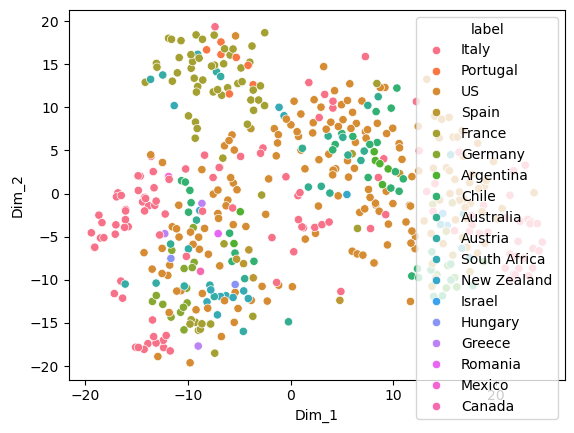

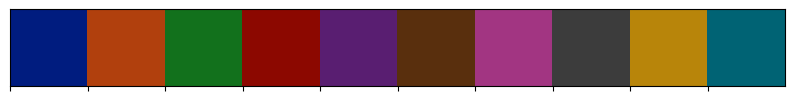

In [25]:
# Picking the top 1000 points as TSNE
# takes a lot of time for 15K points
data_500 = standardized_data[0:500, :]
labels_500 = l[0:500]
 
model = TSNE(n_components = 2, random_state = 0)
# configuring the parameters
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations
# for the optimization = 1000
 
tsne_data = model.fit_transform(data_500)
 
# creating a new data frame which
# help us in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels_500)).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("Dim_1", "Dim_2", "label"))
 
# Plotting the result of tsne
sns.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
               hue='label')
custom_palette = sns.color_palette("dark")
sns.palplot(custom_palette)
plt.show()

In [18]:
import string

a red wine that does not smell like horse
a red horse that does not smell like wine

a tart not sweet wine
a sweet wine not tart



'your custom word here' in model.wv
user_input = 'Red wine with, juicy..... fruity dessert flavors laser-like dkljgbioerubgowrbgowergbwoergb'

# Text box that takes user input js
# [  'Red wine with juicy fruity dessert flavors' ]  => pass to flask in a post

'Red wine with juicy fruity dessert flavors'
user_input_nopunc = user_input.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
print(user_input)
print(user_input_nopunc)
# in flask
description = [word.lower().strip() for word in user_input_nopunc.split()]
clean_description = [w for w in description if w in model.wv]
sum(model.wv[word] for word in clean_description)
# take words in the description, get the vectors (if they exist), combine them and find similar with cosine similarity



# import your model
# import your description vectors

# Then  create routes and stuff




SyntaxError: invalid syntax (3007977766.py, line 3)

In [ ]:
# Separate data in target and features variables
# Preprocess data
# Divide into train and test data

In [ ]:
# Input vector data into ML algorithm
# Apply K-Means Clustering
# Generate scatter plot of results

In [ ]:
# Input vector data into ML algorithm
# Apply 2nd Model (TBD)
# Generate scatter plot of results

In [ ]:
# Classify using Random Forest

In [ ]:
# Print accuracy score and confusion matrix